In [ ]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
!pip3 install Keras-Preprocessing==1.0.5

In [ ]:
!pip3 install attention

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os

In [ ]:
location = "/content/drive/My Drive/ML Project/Reviews.csv"
sys.path.append(os.path.abspath(location))

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM, Input, Embedding, Dense, TimeDistributed, Concatenate, Attention

In [ ]:
!pip install keras-attention

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
 
#authenticate
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Amazon Fine Food Reviews Data
data = drive.CreateFile({'id': '1f6ejLdBoG7TfCtFNRPFOUwbfUjvV7IjB'}) #https://drive.google.com/file/d/1f6ejLdBoG7TfCtFNRPFOUwbfUjvV7IjB/view?usp=sharing
data.GetContentFile('Reviews.csv')

In [ ]:
df = pd.read_csv("/content/drive/My Drive/ML Project/Reviews.csv")
df = df.sample(n = 150000)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
222261,222262,B004E4CCSQ,A3R9X003XW0LNR,"Deborah Verlen ""Deborah""",0,0,3,1328054400,Not your mother's peach tea,"First, I feel a bit like a fraud reviewing this as I didn't get it so much for the tea as I did for another use--based on another reviewer's experiences. She found when her bottle was leaking and ..."
408815,408816,B000KGW2BY,A37XF3OXUBXK9E,Scrina,0,0,5,1216512000,"Delicious, Healthy and Kids love them","These are wonderful!!! They have a great crunchy texture, buttery flavor with the right amount of salt. The only bad thing I can say about them is they are HIGHLY ADDICTIVE!! My 6 year old love..."
170445,170446,B000MXEN9O,AQBEWYC4FNJFL,"Dave in DC ""Dave""",2,2,5,1263772800,Fantastic for little fingers,We attribute our son's new-found interest in eating finger foods to these little cheese sticks. He first discovered them on a visit to grandma's. They're perfect - long enough that he can hold t...
544597,544598,B001P3PR54,A3RA1ERQY1WH13,"Robert F. Weber ""Dog Lover""",0,0,5,1231200000,Dog Chew Tasty!,My 2 Westies LOVE these chews! One is not enough. The price I pay at my local Vet is about twice what I pay (including S&H) from this vendor.
252914,252915,B005OHBN1Y,A8J21NO1JKRQ8,Lana,1,1,5,1347753600,Great lunch addition,"My kindergartener really loves taking this to school in the lunch box. Perfect size, and just the kind of healthy snack I like to send."


In [ ]:
df.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
df.dropna(axis=0,inplace=True)

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
222261,222262,B004E4CCSQ,A3R9X003XW0LNR,"Deborah Verlen ""Deborah""",0,0,3,1328054400,Not your mother's peach tea,"First, I feel a bit like a fraud reviewing this as I didn't get it so much for the tea as I did for another use--based on another reviewer's experiences. She found when her bottle was leaking and ..."
408815,408816,B000KGW2BY,A37XF3OXUBXK9E,Scrina,0,0,5,1216512000,"Delicious, Healthy and Kids love them","These are wonderful!!! They have a great crunchy texture, buttery flavor with the right amount of salt. The only bad thing I can say about them is they are HIGHLY ADDICTIVE!! My 6 year old love..."
170445,170446,B000MXEN9O,AQBEWYC4FNJFL,"Dave in DC ""Dave""",2,2,5,1263772800,Fantastic for little fingers,We attribute our son's new-found interest in eating finger foods to these little cheese sticks. He first discovered them on a visit to grandma's. They're perfect - long enough that he can hold t...
544597,544598,B001P3PR54,A3RA1ERQY1WH13,"Robert F. Weber ""Dog Lover""",0,0,5,1231200000,Dog Chew Tasty!,My 2 Westies LOVE these chews! One is not enough. The price I pay at my local Vet is about twice what I pay (including S&H) from this vendor.
252914,252915,B005OHBN1Y,A8J21NO1JKRQ8,Lana,1,1,5,1347753600,Great lunch addition,"My kindergartener really loves taking this to school in the lunch box. Perfect size, and just the kind of healthy snack I like to send."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125580 entries, 222261 to 77051
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      125580 non-null  int64 
 1   ProductId               125580 non-null  object
 2   UserId                  125580 non-null  object
 3   ProfileName             125580 non-null  object
 4   HelpfulnessNumerator    125580 non-null  int64 
 5   HelpfulnessDenominator  125580 non-null  int64 
 6   Score                   125580 non-null  int64 
 7   Time                    125580 non-null  int64 
 8   Summary                 125580 non-null  object
 9   Text                    125580 non-null  object
dtypes: int64(5), object(5)
memory usage: 10.5+ MB


In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [ ]:
cleaned_text = []
for t in df['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [ ]:
cleaned_text[:5]

['first feel bit like fraud reviewing get much tea another use based another reviewer experiences found bottle leaking left sink excess liquid leaking cleaned stained sink feelings liquid used tea mixed peach favorite flavor like good herbal tea hot day liquid tea left bit chemical taste unable get liquid tea vs amount water right satisfied seemed either weak strong reason ordered product cleaning tile shower let grandchildren use washable crayons tile still cannot get crayon dabbed liquid full strength get crayon wow clean white tiles shine scrubbed crayon markings tile shone areas tea brushed wiped also clean looked ingredients sure one cleaning impressive little expensive shower cleaner might worth stubborn stains therefore giving product three stars one star tea five shower cleaner average three',
 'wonderful great crunchy texture buttery flavor right amount salt bad thing say highly addictive year old love friends happy substitute things like potato chips treat like chips calories

In [ ]:
cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [ ]:
cleaned_summary[:10]

['not your mother peach tea',
 'delicious healthy and kids love them',
 'fantastic for little fingers',
 'dog chew tasty',
 'great lunch addition',
 'do not get orange flavor',
 'arrived days after the best before date',
 'bertie botts beans',
 'do not ever buy this product',
 'no sulphur dioxide']

In [ ]:
df['cleaned_text']=cleaned_text
df['cleaned_summary']=cleaned_summary

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,cleaned_summary
222261,222262,B004E4CCSQ,A3R9X003XW0LNR,"Deborah Verlen ""Deborah""",0,0,3,1328054400,Not your mother's peach tea,"First, I feel a bit like a fraud reviewing this as I didn't get it so much for the tea as I did for another use--based on another reviewer's experiences. She found when her bottle was leaking and ...",first feel bit like fraud reviewing get much tea another use based another reviewer experiences found bottle leaking left sink excess liquid leaking cleaned stained sink feelings liquid used tea m...,not your mother peach tea
408815,408816,B000KGW2BY,A37XF3OXUBXK9E,Scrina,0,0,5,1216512000,"Delicious, Healthy and Kids love them","These are wonderful!!! They have a great crunchy texture, buttery flavor with the right amount of salt. The only bad thing I can say about them is they are HIGHLY ADDICTIVE!! My 6 year old love...",wonderful great crunchy texture buttery flavor right amount salt bad thing say highly addictive year old love friends happy substitute things like potato chips treat like chips calories grams fat ...,delicious healthy and kids love them
170445,170446,B000MXEN9O,AQBEWYC4FNJFL,"Dave in DC ""Dave""",2,2,5,1263772800,Fantastic for little fingers,We attribute our son's new-found interest in eating finger foods to these little cheese sticks. He first discovered them on a visit to grandma's. They're perfect - long enough that he can hold t...,attribute son new found interest eating finger foods little cheese sticks first discovered visit grandma perfect long enough hold hand still bite ends appears think quite delicious start intereste...,fantastic for little fingers
544597,544598,B001P3PR54,A3RA1ERQY1WH13,"Robert F. Weber ""Dog Lover""",0,0,5,1231200000,Dog Chew Tasty!,My 2 Westies LOVE these chews! One is not enough. The price I pay at my local Vet is about twice what I pay (including S&H) from this vendor.,westies love chews one enough price pay local vet twice pay vendor,dog chew tasty
252914,252915,B005OHBN1Y,A8J21NO1JKRQ8,Lana,1,1,5,1347753600,Great lunch addition,"My kindergartener really loves taking this to school in the lunch box. Perfect size, and just the kind of healthy snack I like to send.",kindergartener really loves taking school lunch box perfect size kind healthy snack like send,great lunch addition


In [ ]:
df.replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

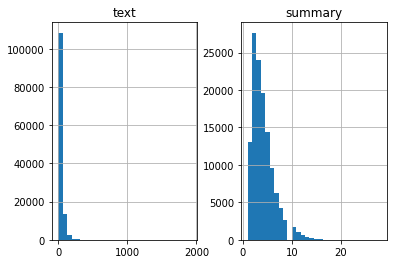

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
cnt=0
for i in df['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(df['cleaned_summary']))

0.9456973908608406


In [ ]:
max_text_len=40
max_summary_len=8

In [ ]:
cleaned_text =np.array(df['cleaned_text'])
cleaned_summary=np.array(df['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
newdf=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
newdf.head()

,text,summary
0,attribute son new found interest eating finger foods little cheese sticks first discovered visit grandma perfect long enough hold hand still bite ends appears think quite delicious start intereste...,fantastic for little fingers
1,westies love chews one enough price pay local vet twice pay vendor,dog chew tasty
2,kindergartener really loves taking school lunch box perfect size kind healthy snack like send,great lunch addition
3,even opened yet wanted warn packages received already days past best date printed package super worried using probably would recommend buying source check date first,arrived days after the best before date
4,told previous review beans good right awful kids enjoyed every miniute harry potter themed birthday every flavoured bean tasting dirt grass pretty realistic vomit bit coconutty taste anyway meant ...,bertie botts beans


In [ ]:
newdf['summary'] = newdf['summary'].apply(lambda x : 'starttok '+ x + ' endtok')

In [ ]:
newdf.head()

,text,summary
0,attribute son new found interest eating finger foods little cheese sticks first discovered visit grandma perfect long enough hold hand still bite ends appears think quite delicious start intereste...,starttok fantastic for little fingers endtok
1,westies love chews one enough price pay local vet twice pay vendor,starttok dog chew tasty endtok
2,kindergartener really loves taking school lunch box perfect size kind healthy snack like send,starttok great lunch addition endtok
3,even opened yet wanted warn packages received already days past best date printed package super worried using probably would recommend buying source check date first,starttok arrived days after the best before date endtok
4,told previous review beans good right awful kids enjoyed every miniute harry potter themed birthday every flavoured bean tasting dirt grass pretty realistic vomit bit coconutty taste anyway meant ...,starttok bertie botts beans endtok


In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(newdf['text']),np.array(newdf['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
x_tr1,x_val1,y_tr1,y_val1=train_test_split(np.array(newdf['text']),np.array(newdf['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
x_tr1[0]

'got husband mail carrier tried one customer gave loved especially hot days personally tried raves bit pricey work like gatorade regular freeze pops'

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 65.93604604254632
Total Coverage of rare words: 2.028260596212253


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

12667

In [ ]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 77.06387466104249
Total Coverage of rare words: 4.068234954811836


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
y_tokenizer.word_counts['starttok'],len(y_tr)

(77569, 77569)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

In [ ]:
!pip --version tensorflow

pip 19.3.1 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)


In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 100)      1266700     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 40, 300), (N 481200      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
298/298 [==============================] - 1895s 6s/step - loss: 2.4832 - val_loss: 2.2779
Epoch 2/10
298/298 [==============================] - 1867s 6s/step - loss: 2.1729 - val_loss: 2.1377
Epoch 3/10
298/298 [==============================] - 1866s 6s/step - loss: 2.0351 - val_loss: 2.0098
Epoch 4/10
298/298 [==============================] - 1862s 6s/step - loss: 1.9410 - val_loss: 1.9463
Epoch 5/10
298/298 [==============================] - 1886s 6s/step - loss: 1.8764 - val_loss: 1.9014
Epoch 6/10
298/298 [==============================] - 1871s 6s/step - loss: 1.8230 - val_loss: 1.8690
Epoch 7/10
298/298 [==============================] - 1875s 6s/step - loss: 1.7778 - val_loss: 1.8370
Epoch 8/10
298/298 [==============================] - 1885s 6s/step - loss: 1.7371 - val_loss: 1.8254
Epoch 9/10
298/298 [==============================] - 1887s 6s/step - loss: 1.7021 - val_loss: 1.8065
Epoch 10/10
298/298 [==============================] - 1881s 6s/step - loss: 1.669

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
75/75 [==============================] - 1683s 22s/step - loss: 2.6557 - val_loss: 2.4644
Epoch 2/10
75/75 [==============================] - 1667s 22s/step - loss: 2.3662 - val_loss: 2.3326
Epoch 3/10
75/75 [==============================] - 1685s 22s/step - loss: 2.2929 - val_loss: 2.2684
Epoch 4/10
75/75 [==============================] - 1680s 22s/step - loss: 2.2297 - val_loss: 2.2293
Epoch 5/10
75/75 [==============================] - 1683s 22s/step - loss: 2.1732 - val_loss: 2.1812
Epoch 6/10
75/75 [==============================] - 1679s 22s/step - loss: 2.1042 - val_loss: 2.1100
Epoch 7/10
75/75 [==============================] - 1697s 23s/step - loss: 2.0360 - val_loss: 2.0454
Epoch 8/10
75/75 [==============================] - 1682s 22s/step - loss: 1.9742 - val_loss: 2.0093
Epoch 9/10
75/75 [==============================] - 1662s 22s/step - loss: 1.9207 - val_loss: 1.9656
Epoch 10/10
75/75 [==============================] - 1666s 22s/step - loss: 1.8750 - val_lo

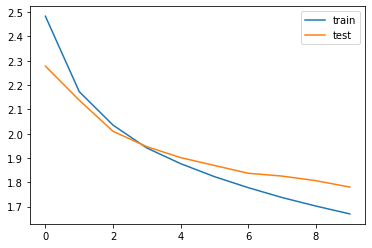

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
_MODEL_NAME = 'LSTM'
model.save('/content/drive/My Drive/ML Project/LSTM.h5')

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['starttok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='endtok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'endtok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['starttok']) and i!=target_word_index['endtok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

' great product'

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: got husband mail carrier tried one customer gave loved especially hot days personally tried raves bit pricey work like gatorade regular freeze pops 
Original summary: hubby loves these especially on hot days 
Predicted summary:  great product


Review: little runny could taste better highly recommend product anyone looking wonderful alternative cheap unnatural crap sell grocery stores 
Original summary: delicious 
Predicted summary:  great product


Review: first thing noticed taste overwhelming figured fine vitamins usually taste terrific afterwards really increase energy instead felt dehydrated nauseous overall sick feeling even worse actually felt tired hours may work people definitely people 
Original summary: did not taste good and did not energy 
Predicted summary:  not bad


Review: great making popcorn stir crazy popper bought suppose really good let know years made live longer 
Original summary: tastes great 
Predicted summary:  great popcorn


Review: really good latt

In [ ]:
!pip install contractions

     |████████████████████████████████| 245kB 6.1MB/s 
     |████████████████████████████████| 317kB 22.9MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81703 sha256=8616aa804e99d717388ffb8503434d3812c93f4e881383f22a1b5ade1cd30daa
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer1 = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer1.fit_on_texts(list(x_tr1))

#convert text sequences into integer sequences
x_tr_seq1    =   x_tokenizer1.texts_to_sequences(x_tr1) 

#padding zero upto maximum length
x_tr1    =   pad_sequences(x_tr_seq1,  maxlen=max_text_len, padding='post')

In [ ]:
print(x_tr1[3])
print(y_tr1[3])
decode_sequence(x_tr2[3].reshape(1,max_text_len))

[   1  264  212 1200  627 1391   31 1597   12    3  415   83   94   57
  406  299    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
starttok tastes great endtok


' great popcorn'

In [ ]:
!pip install rouge

In [ ]:
import rouge

In [ ]:
rouge.Rouge()

In [ ]:
# storing all the rouge scores
rouge_1 = {'f':[], 'p':[], 'r':[]}
rouge_2 = {'f':[], 'p':[], 'r':[]}
rouge_l = {'f':[], 'p':[], 'r':[]}

In [ ]:
from rouge import Rouge
scorer = Rouge()

In [ ]:
decode_sequence(x_tr2[0].reshape(1,max_text_len))

' great product'

In [ ]:
for i in range(len(x_tr1)):
  #text = df['text'][i]
  reference = ' '.join(y_tr1[i].split()[1:-1])
  if len(reference) == 0:
    continue
  hypothesis = decode_sequence(x_tr2[0].reshape(1,max_text_len))
  scores = scorer.get_scores(hypothesis, reference)[0]
  one, two, l = scores['rouge-1'], scores['rouge-2'], scores['rouge-l']
  for p, q in one.items():
    rouge_1[p].append(q)
  for p, q in two.items():
    rouge_2[p].append(q)
  for p, q in l.items():
    rouge_l[p].append(q)

In [ ]:
arr1=list()
arr1.append(["Rouge 1",np.mean(rouge_1['f']), np.mean(rouge_1['p']), np.mean(rouge_1['r'])])
arr1.append(["Rouge 2",np.mean(rouge_2['f']), np.mean(rouge_2['p']), np.mean(rouge_2['r'])])
arr1.append(["Rouge l",np.mean(rouge_l['f']), np.mean(rouge_l['p']), np.mean(rouge_l['r'])])

In [ ]:
Rouge=["Rouge 1","Rouge 2","Rouge l"]
df_final=pd.DataFrame(arr1,columns=["Rouge","f","p","r"],)

In [ ]:
df_final

,Rouge,f,p,r
0,Rouge 1,0.216487,0.234169,0.220418
1,Rouge 2,0.101648,0.095162,0.110700
2,Rouge l,0.246894,0.253975,0.240963
